In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm
import itertools as it

# holt's linear trend model. 
from statsmodels.tsa.api import Holt
from prophet import Prophet

#important import 
import pandas as pd
import numpy as np
import os
import wrangle as w

Importing plotly failed. Interactive plots will not work.


In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
#Acquire superstore data from codeup database
df = w.get_superstore_data()

In [4]:
df.head()

,Region ID,Category ID,Product ID,Customer ID,Order ID,Order Date,Ship Date,Ship Mode,Segment,Country,...,Postal Code,Sales,Quantity,Discount,Profit,Customer Name,Product Name,Category,Sub-Category,Region Name
0,1,1,FUR-BO-10001798,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,...,42420.0,261.9600,2.0,0.00,41.9136,Claire Gute,Bush Somerset Collection Bookcase,Furniture,Bookcases,South
1,1,2,FUR-CH-10000454,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,...,42420.0,731.9400,3.0,0.00,219.5820,Claire Gute,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,South
2,1,4,FUR-TA-10000577,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,...,33311.0,957.5775,5.0,0.45,-383.0310,Sean O'Donnell,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,South
3,1,5,OFF-ST-10000760,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,...,33311.0,22.3680,2.0,0.20,2.5164,Sean O'Donnell,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,South
4,1,11,OFF-PA-10002365,AA-10480,CA-2017-114412,2017-04-15,2017-04-20,Standard Class,Consumer,United States,...,28027.0,15.5520,3.0,0.20,5.4432,Andrew Allen,Xerox 1967,Office Supplies,Paper,South


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1733
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region ID      1734 non-null   int64  
 1   Category ID    1734 non-null   int64  
 2   Product ID     1734 non-null   object 
 3   Customer ID    1734 non-null   object 
 4   Order ID       1734 non-null   object 
 5   Order Date     1734 non-null   object 
 6   Ship Date      1734 non-null   object 
 7   Ship Mode      1734 non-null   object 
 8   Segment        1734 non-null   object 
 9   Country        1734 non-null   object 
 10  City           1734 non-null   object 
 11  State          1734 non-null   object 
 12  Postal Code    1734 non-null   float64
 13  Sales          1734 non-null   float64
 14  Quantity       1734 non-null   float64
 15  Discount       1734 non-null   float64
 16  Profit         1734 non-null   float64
 17  Customer Name  1734 non-null   object 
 18  Product 

In [6]:
#Checking the nulls
df.isnull().sum().sum()

0

In [7]:
#Cleaning superstore data
df = w.prep_superstore(df, 'Order Date', 'Ship Date')

In [8]:
#Check to see if function rename the columns correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1734 entries, 2014-01-04 to 2017-12-30
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ship_date      1734 non-null   datetime64[ns]
 1   ship_mode      1734 non-null   object        
 2   segment        1734 non-null   object        
 3   country        1734 non-null   object        
 4   city           1734 non-null   object        
 5   state          1734 non-null   object        
 6   postal_code    1734 non-null   float64       
 7   sales          1734 non-null   float64       
 8   quantity       1734 non-null   float64       
 9   discount       1734 non-null   float64       
 10  profit         1734 non-null   float64       
 11  customer_name  1734 non-null   object        
 12  product_name   1734 non-null   object        
 13  category       1734 non-null   object        
 14  sub_category   1734 non-null   object        
 15  reg

In [9]:
#Let's take a look about the statistics of numeric values in the data.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
postal_code,1734.0,53501.926182,32180.245224,1841.0000,19143.0000,50315.00000,85705.00000,98661.000
sales,1734.0,229.206358,532.862614,1.0800,16.6950,52.24500,209.91750,8159.952
quantity,1734.0,3.794694,2.297407,1.0000,2.0000,3.00000,5.00000,14.000
discount,1734.0,0.160110,0.206419,0.0000,0.0000,0.20000,0.20000,0.800
profit,1734.0,21.880351,202.891949,-3839.9904,1.7024,8.07305,27.41445,3177.475


In [10]:
#Let's see how many categories of products we have in the data.
df.category.unique()

array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

In [11]:
df.category.value_counts()

Office Supplies    1055
Furniture           360
Technology          319
Name: category, dtype: int64

**Explore**

<AxesSubplot:xlabel='Order Date'>

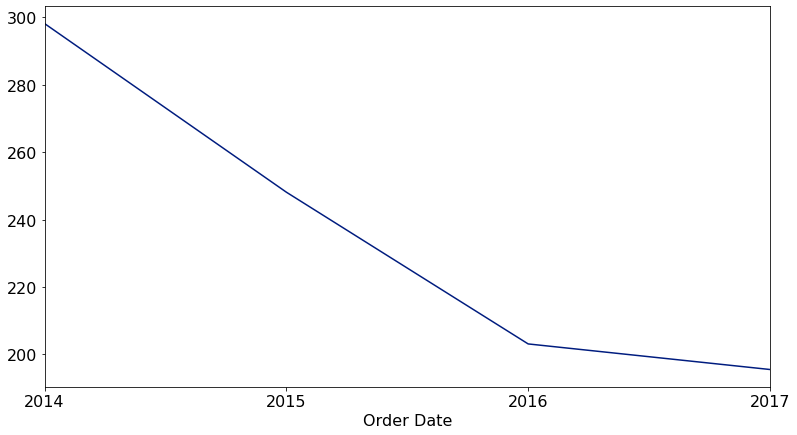

In [12]:
#Look at the sales over the years
df.resample('Y').sales.mean().plot()

<AxesSubplot:xlabel='Order Date'>

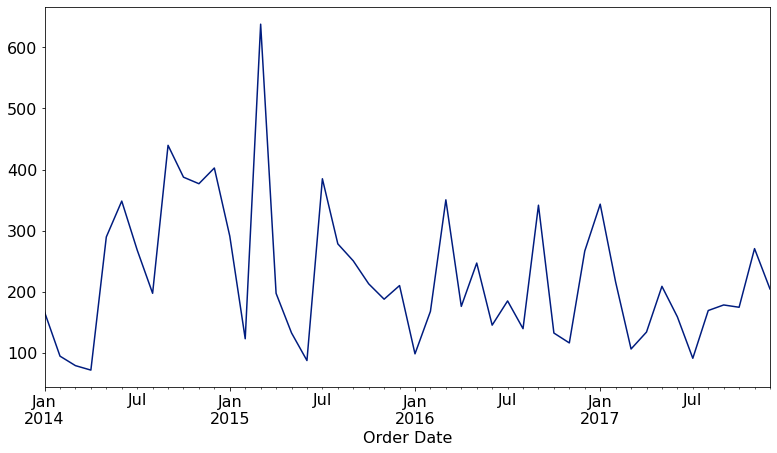

In [13]:
#Look at the sales for every month
df.resample('MS').sales.mean().plot()

**Look deeper into category**

In [14]:
train, validate, test = w.split_time_series_data(df)

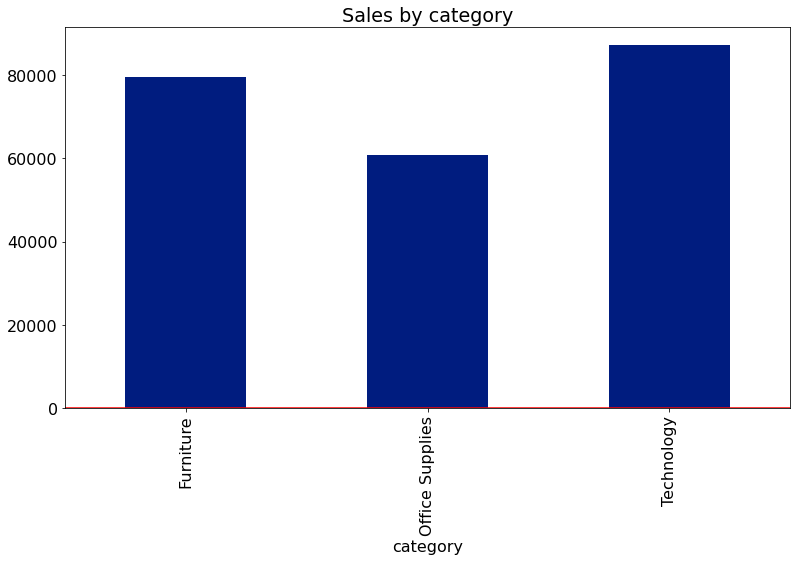

In [15]:
#Visualize the sales data
train.groupby('category').sales.sum().plot.bar()
plt.title('Sales by category')
plt.axhline(train.profit.mean(), color = 'r')

Text(0, 0.5, 'Total Sales')

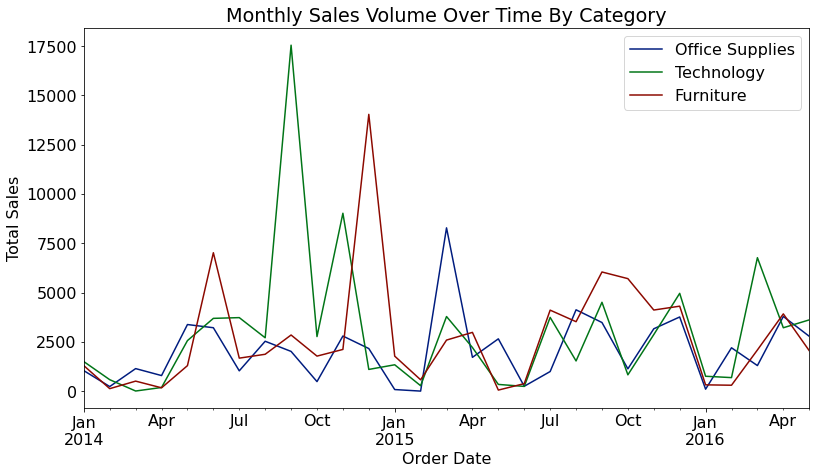

In [16]:
#Better graph
for c in train.category.unique():
    sample = train[train.category == c]
    sample.resample('M').sales.sum().plot(label=c)
    plt.legend()
plt.title("Monthly Sales Volume Over Time By Category")
plt.ylabel("Total Sales")

Text(0, 0.5, 'Total Sales')

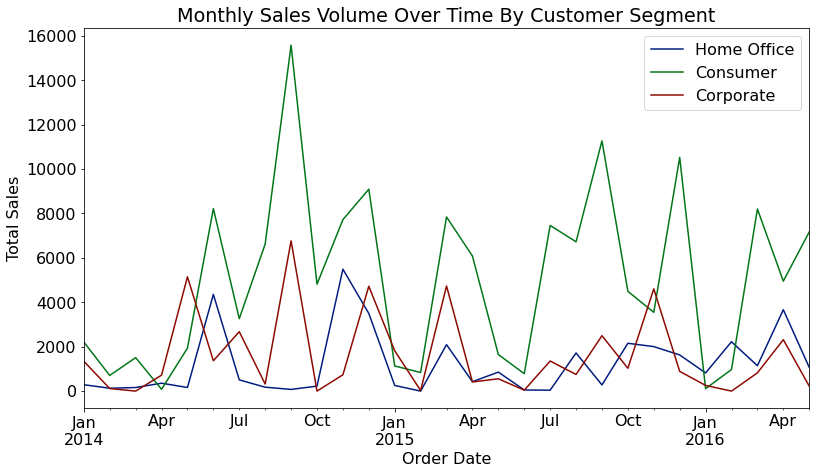

In [17]:
for s in train.segment.unique():
    sample = train[train.segment == s]
    sample.resample('M').sales.sum().plot(label=s)
    plt.legend()
plt.title("Monthly Sales Volume Over Time By Customer Segment")
plt.ylabel("Total Sales")

In [18]:
#Extract the data of Office Supplies, technology and furniture
office_supplies = train.loc[train['category'] == 'Office Supplies']
furniture = train.loc[train['category'] == 'Furniture']
technology = train.loc[train['category'] == 'Technology']

In [19]:
office_supplies = office_supplies[['sales']]

In [20]:
office_supplies = office_supplies.sort_values('Order Date')
office_supplies = office_supplies.groupby('Order Date')['sales'].sum().reset_index()
office_supplies = office_supplies.set_index('Order Date')
office_supplies.head()

,sales
Order Date,
2014-01-04,288.060
2014-01-09,9.344
2014-01-10,2.890
2014-01-13,640.520
2014-01-16,48.660


In [21]:
#using the start of each month as the timestamp
monthly = office_supplies['sales'].resample('MS').mean()

In [22]:
furniture = furniture[['sales']]
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.head()

,sales
Order Date,
2014-01-10,51.940
2014-01-11,9.940
2014-01-16,127.104
2014-01-20,1106.540
2014-02-12,129.568


In [23]:
monthly_office = monthly
monthly_furniture = furniture['sales'].resample('MS').mean()

In [24]:
furniture = pd.DataFrame({'Order Date':monthly_furniture.index, 'Sales':monthly_furniture.values})
office = pd.DataFrame({'Order Date': monthly_office.index, 'Sales': monthly_office.values})

store = furniture.merge(office, how = 'inner', on = 'Order Date')
store.rename(columns = {'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,323.881000,173.734000
1,2014-02-01,129.568000,58.909500
2,2014-03-01,170.528000,163.820286
3,2014-04-01,86.112000,99.149250
4,2014-05-01,216.171333,483.108000


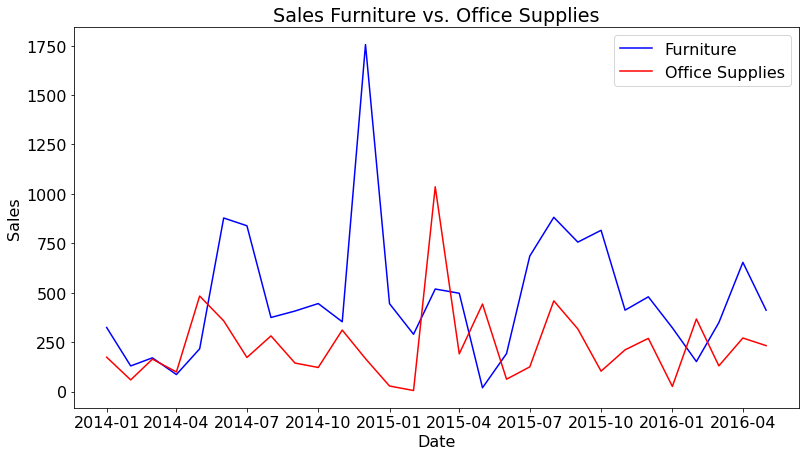

In [25]:
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'Furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Furniture vs. Office Supplies')
plt.legend()
plt.show()

The figure above clearly shows the seasonality in our data, and the trend is gradually increasing through the years.

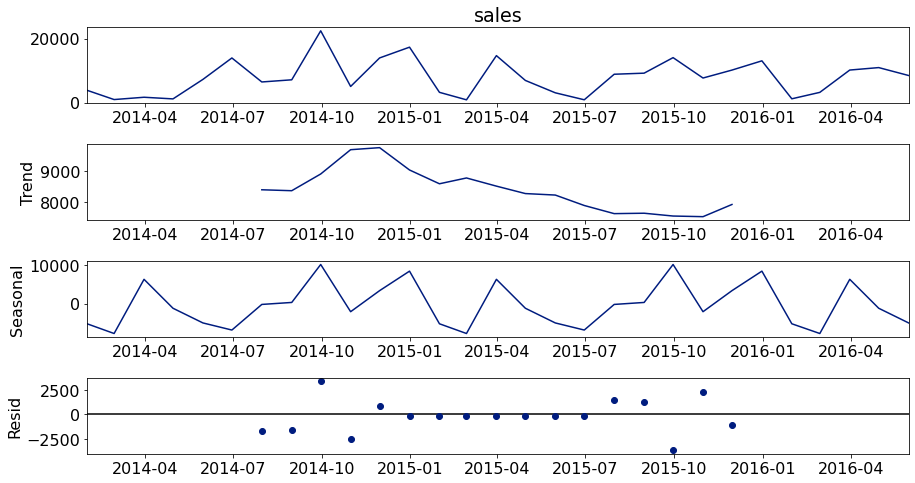

In [26]:
# Using decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
y = train.resample('M').sales.sum()
sm.tsa.seasonal_decompose(y).plot()
None

Text(0.5, 1.0, 'No real relationship in lag plot of 1 month')

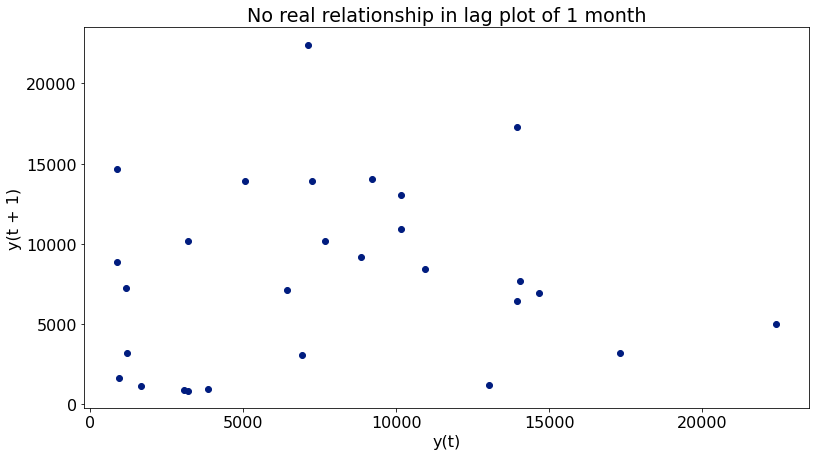

In [27]:
#lag plot
# the lag plot does not demonstrate a clearly identifiable pattern in monthly.
#Try weekly maybe?
monthly_sales = train.resample('M').sales.sum()
pd.plotting.lag_plot(monthly_sales, lag = 1)
plt.title("No real relationship in lag plot of 1 month")

**Modeling**

In [28]:
#From the lesson
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    yhat_df = pd.DataFrame({'sales': [sales],
                           }, index = validate.index)
    return yhat_df

In [29]:
# create an empty dataframe to store model type, our avg_temp, and its rmse.
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [30]:
#Drop everything except sales
train = train[['sales']]
validate = validate[['sales']]
test = test[['sales']]

**Last observed value**

Last Observed Value: The future will look like the now

In [31]:
sales = train['sales'][-1:][0]
sales

41.37

In [32]:
#predictions based on last observed value
yhat_df = pd.DataFrame({'sales': [sales]},  
                      index = validate.index)

yhat_df.head()

,sales
Order Date,
2016-05-26,41.37
2016-05-26,41.37
2016-05-26,41.37
2016-05-26,41.37
2016-05-26,41.37


sales -- RMSE: 448


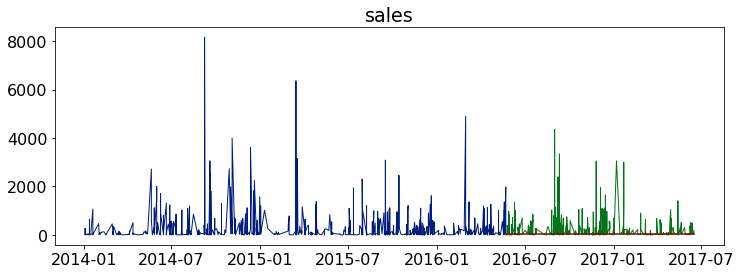

In [33]:
plot_and_eval('sales')

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0


**Simple Average**

The future will look, on average, like history.

In [35]:
sales = round(train['sales'].mean(),2)
#predictions with simple average
yhat_df = pd.DataFrame({'sales': [sales]},  
                      index = validate.index)

sales -- RMSE: 426


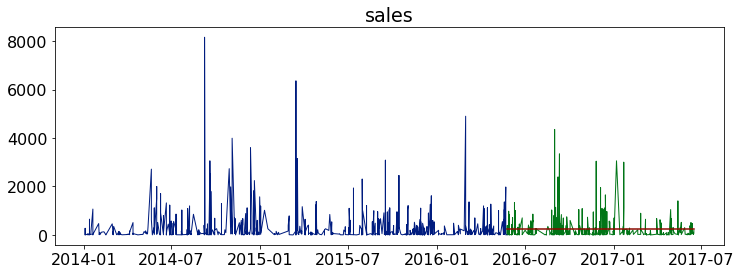

In [36]:
plot_and_eval(col)

In [37]:
eval_df = append_eval_df(model_type='simple_average', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0
1,simple_average,sales,426.0


**Moving Average**

The future will look, on average, like recent history.

In [38]:
#Sales for 3 months
sales = round(train['sales'].rolling(3).mean()[-1], 2)
yhat_df = make_predictions()

sales -- RMSE: 455


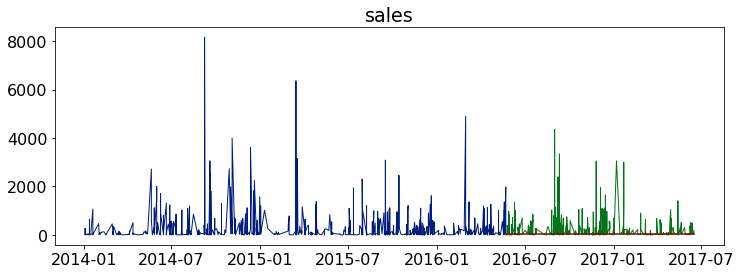

In [39]:
plot_and_eval('sales')

In [40]:
eval_df = append_eval_df(model_type='3 month moving average', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0
1,simple_average,sales,426.0
2,3 month moving average,sales,455.0


In [41]:
#What about 6months, one year, two years and so on for moving average
periods = [6, 9, 12, 24, 36, 48]

for p in periods:
    sales = round(train['sales'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0
1,simple_average,sales,426.0
2,3 month moving average,sales,455.0
3,6 month moving average,sales,448.0
4,9 month moving average,sales,453.0
5,12 month moving average,sales,464.0
6,24 month moving average,sales,431.0
7,36 month moving average,sales,423.0
8,48 month moving average,sales,423.0


In [43]:
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [44]:
#Return the least rmse
eval_df[((eval_df.rmse == min_rmse_amount))]

,model_type,target_var,rmse
7,36 month moving average,sales,423.0
8,48 month moving average,sales,423.0


**Prophet**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [45]:
# Create the model

model = Prophet()

# Fit the model

model.fit(pd.DataFrame({
    'ds' : train.index,
    'y' : train.sales
}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.6455


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1865.23   2.52866e-06       86.0685           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1865.23   1.14194e-05       96.4205   1.481e-07       0.001      186  LS failed, Hessian reset 
     135       1865.23   1.22429e-07       65.2878      0.3615      0.3615      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [46]:
# Make predictions
future = model.make_future_dataframe(450)
results = model.predict(future)
predictions = results[['ds', 'yhat']].set_index('ds')
predictions.columns = ['sales']
predictions = predictions.resample('W').mean()

In [47]:
eval_df = append_eval_df(model_type = 'Prophet', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,448.0
1,simple_average,sales,426.0
2,3 month moving average,sales,455.0
3,6 month moving average,sales,448.0
4,9 month moving average,sales,453.0
5,12 month moving average,sales,464.0
6,24 month moving average,sales,431.0
7,36 month moving average,sales,423.0
8,48 month moving average,sales,423.0
9,Prophet,sales,423.0


sales -- RMSE: 423


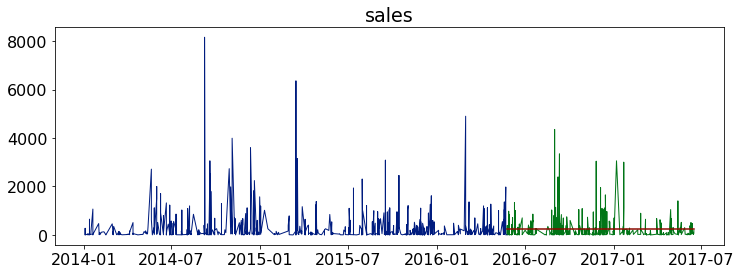

In [48]:
#visualize predictions for 2016 based off previous year cycle
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [49]:
def final_plot(target_var):
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.7)
    plt.title(target_var)
    plt.show()

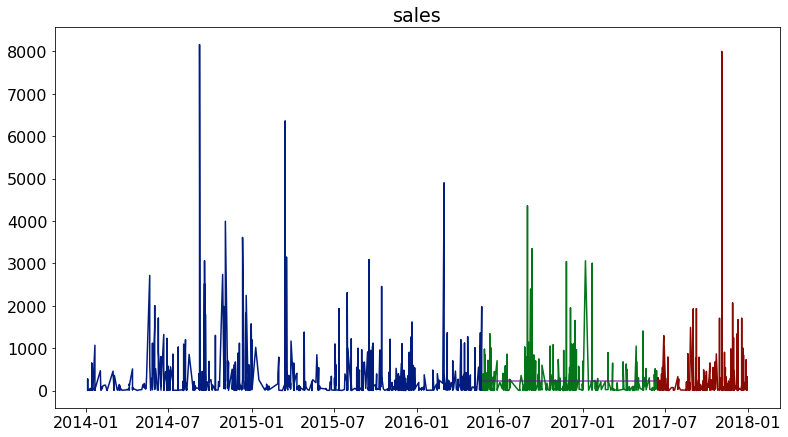

In [50]:
#look at final plot for predictions of 2017. 
for col in train.columns:
    final_plot(col)

In [57]:
#what if we predict 2018
yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

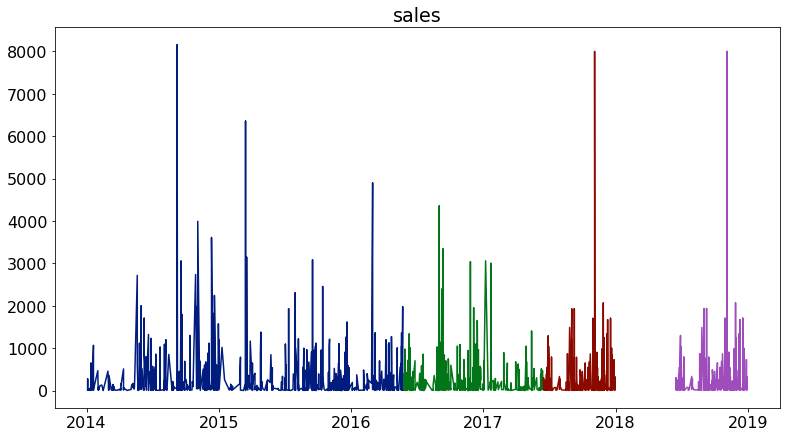

In [60]:
#final plot with prediction of 2013
for col in train.columns:
    final_plot(col)